# low-resolution spatial multimodal data integration using Palette

Although **Palette** was developed for mosaic integration of multimodal data at single-cell resolution, it is also applicable to lower-resolution data (such as 10x Visium multimodal data) integration tasks.

In this tutorial, we applied **Palette** on [human tonsil 10x Genomics Visium data](https://doi.org/10.1101/2024.10.02.616189), which enables simultaneous measurement of RNA and surface protein abundance by the sequencing of antibody-derived tags (ADTs). Due to the platform’s inherent spatial resolution limitations, each spot captures mixed signals from multiple cells. We simulated a realistic mosaic integration scenario by excluding protein and RNA data in the second and third sections, respectively.

In [1]:
library(PaletteSC)
library(uwot)
library(cowplot)
library(RColorBrewer)
library(ggplot2)
library(RColorBrewer)
library(scattermore)
library(ggsci)

Loading required package: Matrix



## Load data

We read in the datasets, with rows as features and columns as cells for all modalities. The highly variable features (HVFs) are already selected and are used to perform integration. For the scRNA-seq data, the top 3000 highly variable genes (HVGs) were identified across batches. For ADT data, we kept all features as input.

In [2]:
setwd('../')
rna1 <- readRDS('./slice1/rna.rds')
rna2 <- readRDS('./slice2/rna.rds')

adt1 <- readRDS('./slice1/adt.rds')
adt3 <- readRDS('./slice3/adt.rds')

dim(rna1)
dim(rna2)
dim(adt1)
dim(adt3)

[1] 3000 4326

[1] 3000 4519

[1]   31 4326

[1]   31 4460

## Create a Palette object

The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for multimodal dataset.

**Palette** accepts data in **list format**, with each element representing a feature-by-cell data matrix. The modality and batch information for each input are provided through ```modals``` and ```samples```.

In [3]:
obj <- Create.Palette.Object(data.list = list(rna1,rna2,adt1,adt3), 
                               samples = c('Batch1','Batch2','Batch1','Batch3'), 
                               modals = c("rna","rna",
                                          "adt",'adt'))
rm(rna1,rna2,adt1,adt3)

## Data preprocessing

For the RNA data, we performed standard log-normalization using the NormalizeData function from the Seurat R package. For the ADT data, we performed centered log ratio transformation.

In [4]:
obj <- Normalize.Data(obj,modal = "rna",normal.method = "LogNormalize")
obj <- Normalize.Data(obj,modal = "adt",normal.method = "CLR",margin = 2)

obj <- Add.HVFs(obj, modal = "rna")
obj <- Add.HVFs(obj, modal = "adt")

No features provide, use all shared features by default.

No features provide, use all shared features by default.



## Clustering but do not perform  representative cells sampling

Within each batch, **Palette** assigns cluster labels to cells using the Louvain algorithm. Next, **Palette** selects a subset of representative cells from each batch. Specifically, silhouette widths (SWs) are computed for all cells based on their clustering labels. 

Here, since the ADT data contains only 31 features, we set the dimension (```dims```) of PCA dimensionality reduction to 20.

Within each clustering label, cells are ranked by their SW values, and the top 25% (by default) are selected. By sampling representative cells, **Palette** is more robust to the low representative cells and is more computationally effective than using all cells in subsequent calculations. 

For data with a low signal-to-noise ratio, the representative cells sampling step is particularly important. To demonstrate the impact of this step on the integration results, we first do not perform representative cell sampling by setting ```downsample = FALSE```.

In [5]:
obj <- Find.Cluster(object = obj, 
                    modal = c("rna",'adt'),
                    dims = list(1:50,1:20),
                    method = c("PCA",'PCA'),
                    downsample = FALSE)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4326
Number of edges: 215608

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7752
Number of communities: 11
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4519
Number of edges: 222049

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7715
Number of communities: 12
Elapsed time: 0 seconds


Warning message in irlba::irlba(scale.list[[x]], nv = max(dim_i), work = max(dim_i) * :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba::irlba(scale.list[[x]], nv = max(dim_i), work = max(dim_i) * :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4326
Number of edges: 161703

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7601
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4460
Number of edges: 143214

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7740
Number of communities: 16
Elapsed time: 0 seconds


## Intra-modal joint dimensionality reduction using Bi-sPCA

**Palette** independently integrating each data modality across batches using **Bi-supervised Principal Component Analysis (Bi-sPCA)**, a new dimensionality reduction model aiming to disentangle biological signals from technical effects. **Bi-sPCA** operates on kernel representations of both biological and technical variation, learning a projection that maximizes biological variation in the embedding while minimizing unwanted technical effects.

```lambda``` balances the relative importance of biological effect and batch effect. If there are strong batch effects between batches, we recommend using a higher ```lambda``` value. To ensure numerical stability, **Palette** restricts 𝜆 to the range `[0,1)`.

When ```joint = TRUE```, all batches within a modality are projected into the same low-dimensional subspace, and the kernel matrix for **Bi-sPCA** is constructed within this space. When ```joint = FALSE```, the batches are reduced pairwise, and the kernel matrix is built based on these pairwise reductions. For datasets with strong batch heterogeneity, we recommend using ```joint = FALSE``` to achieve optimal integration. ```cos.dims``` controls the dimension number of the subspace. And ```sub.dims``` specifies the dimension number of the Bi-sPCA results.

To alleviate the computational burden of applying **Bi-sPCA** to datasets with extremely high feature dimensionality, such as scATAC-seq data, **Palette** incorporates two pre-dimensionality reduction strategies. If the matrix dimension exceeds ```RP_thresh```, pre-dimensionality reduction will be performed. ```pre.reduce``` controls whether to perform LSI (SVD) before **Bi-sPCA**. If ```pre.reduce=FALSE```, the random projection (RP) algorithm is used for pre-dimensionality reduction. For large-scale data, LSI pre-dimensionality 

In [6]:
obj <- Find.Subspace(obj,modal = c("rna",'adt'),
                     lambda = list(0.8,0.8),
                     joint = TRUE,
                     sub.dims = list(1:40,1:15),
                     cos.dims = list(1:50,1:20),
                     pre.reduce = FALSE,
                     RP_thresh = 10000)

Performing pair-wise dimensionality reduction and L2 normalization, and identifying batch-specific cluster median cosine similarity. 


Done !

Performing pair-wise dimensionality reduction and L2 normalization, and identifying batch-specific cluster median cosine similarity. 


Warning message in irlba::irlba(d, nv = n.dims, work = min(1000, n.dims * 3)):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Done !



## MBG-guided inferring of missing modality matrices and Cross-batch alignment

**Palette** constructs a **mosaic bipartite graph (MBG)** to capture the structural topology of data. The **MBG** is an undirected, unweighted, and connected bipartite graph where nodes represent batches and modalities, and edges indicate the presence of a given modality in a batch. This graph sequentially connects the partially overlapping modalities across batches. For batches that lack measurements in specific modalities, **Palette** identifies shortest paths in the **MBG** that connect the batch to the missing modality. These paths define biologically informed propagation routes across the latent spaces of the shared modalities, enabling inference of low-dimensional representations for unobserved modalities by transferring information through matched neighbors across batches. **Palette** employs multiple paths to infer the missing data for each cell in a weighted approach. Finally, both real and inferred representations of all batches are jointly embedded into a unified low-dimensional space using **Bi-sPCA** again.

In [7]:
obj <- Run.Palette(obj)

Constructing MBG.

MBG Done!

Inferring missing modality matrices guided by MBG.


Performing inference for modal "adt" of  sample "Batch2" in embedding space.


Performing inference for modal "rna" of  sample "Batch3" in embedding space.


MBG-guided inferring Done.


Cross-batch alignment.


Palette integration Done! 




## Visualization

In [8]:
meta <- readRDS('../meta.rds')
colnames(meta) <- c('Barcode','Annotation','X','Y','Batch')

In [9]:
Palette_emb <- as.matrix(obj@Int.result[["bind"]][rownames(meta),])
Palette_umap = as.data.frame(umap(Palette_emb))
colnames(Palette_umap) = c("UMAP1", "UMAP2")
Palette_umap = cbind.data.frame(meta, Palette_umap)
fig.size = function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

Based on the UMAP visualization results, we observed that the labels of different tissue annotations showed a mixed state (right image)

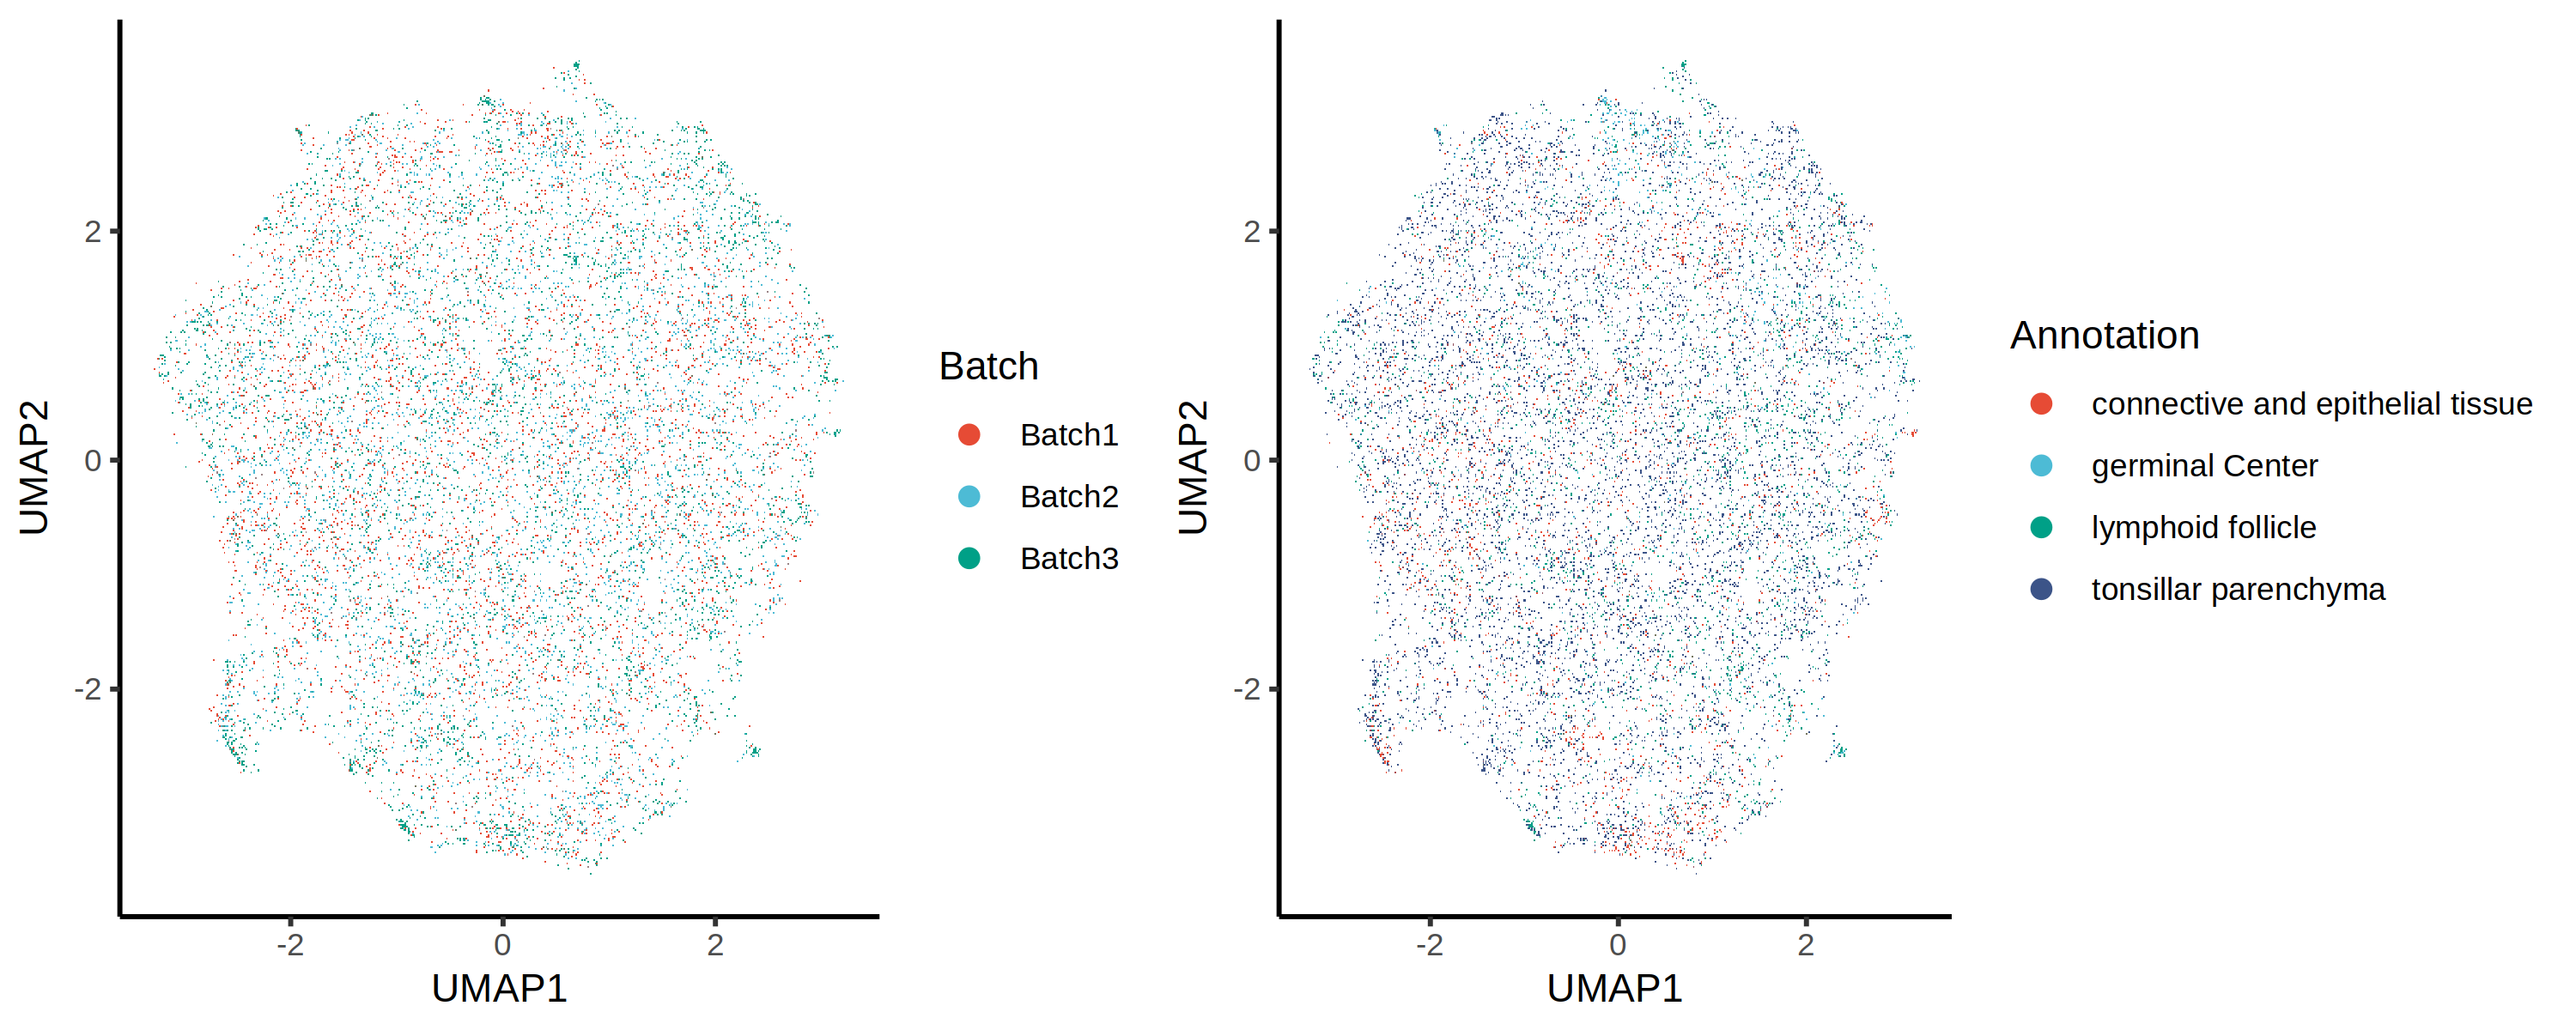

In [10]:
p1 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Batch)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

p2 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Annotation)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

fig.size(4,10)
plot_grid(p1, p2,align = 'h', axis = "b",nrow = 1,rel_widths = c(4.5,5.5))

## Representative cells sampling

Next, we return to the clustering step and sample representative cells based on the cluster labels. We have obtained the cluster labels through the Find.Cluster function. Next, we use the DownSample function to perform representative cell sampling. We set ```supervised``` to ```FALSE``` to specify sampling in an unsupervised scenario.

In [11]:
obj <- DownSample(obj,modal = c('rna','adt'),
                  supervised = FALSE,
                  dims = list(1:50,1:20),
                  method = c("PCA","PCA"))

Warning message in irlba::irlba(scale.list[[x]], nv = max(dim_i), work = max(dim_i) * :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba::irlba(scale.list[[x]], nv = max(dim_i), work = max(dim_i) * :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


Next, we perform the subsequent steps to obtain the final integration result

In [12]:
obj <- Find.Subspace(obj,modal = c("rna",'adt'),
                     lambda = list(0.8,0.8),
                     joint = TRUE,
                     sub.dims = list(1:40,1:15),
                     cos.dims = list(1:50,1:20),
                     pre.reduce = FALSE,
                     RP_thresh = 10000)
obj <- Run.Palette(obj)

Performing pair-wise dimensionality reduction and L2 normalization, and identifying batch-specific cluster median cosine similarity. 


Done !

Performing pair-wise dimensionality reduction and L2 normalization, and identifying batch-specific cluster median cosine similarity. 


Warning message in irlba::irlba(d, nv = n.dims, work = min(1000, n.dims * 3)):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Done !

Constructing MBG.

MBG Done!

Inferring missing modality matrices guided by MBG.


Performing inference for modal "adt" of  sample "Batch2" in embedding space.


Performing inference for modal "rna" of  sample "Batch3" in embedding space.


MBG-guided inferring Done.


Cross-batch alignment.


Palette integration Done! 




## Visualization

In [13]:
Palette_emb <- as.matrix(obj@Int.result[["bind"]][rownames(meta),])
Palette_umap = as.data.frame(umap(Palette_emb))
colnames(Palette_umap) = c("UMAP1", "UMAP2")
Palette_umap = cbind.data.frame(meta, Palette_umap)

Through UMAP visualization results, we observe that the integrated embedding not only integrates data across batches (modalities) but also discriminates between different tissue annotation labels.

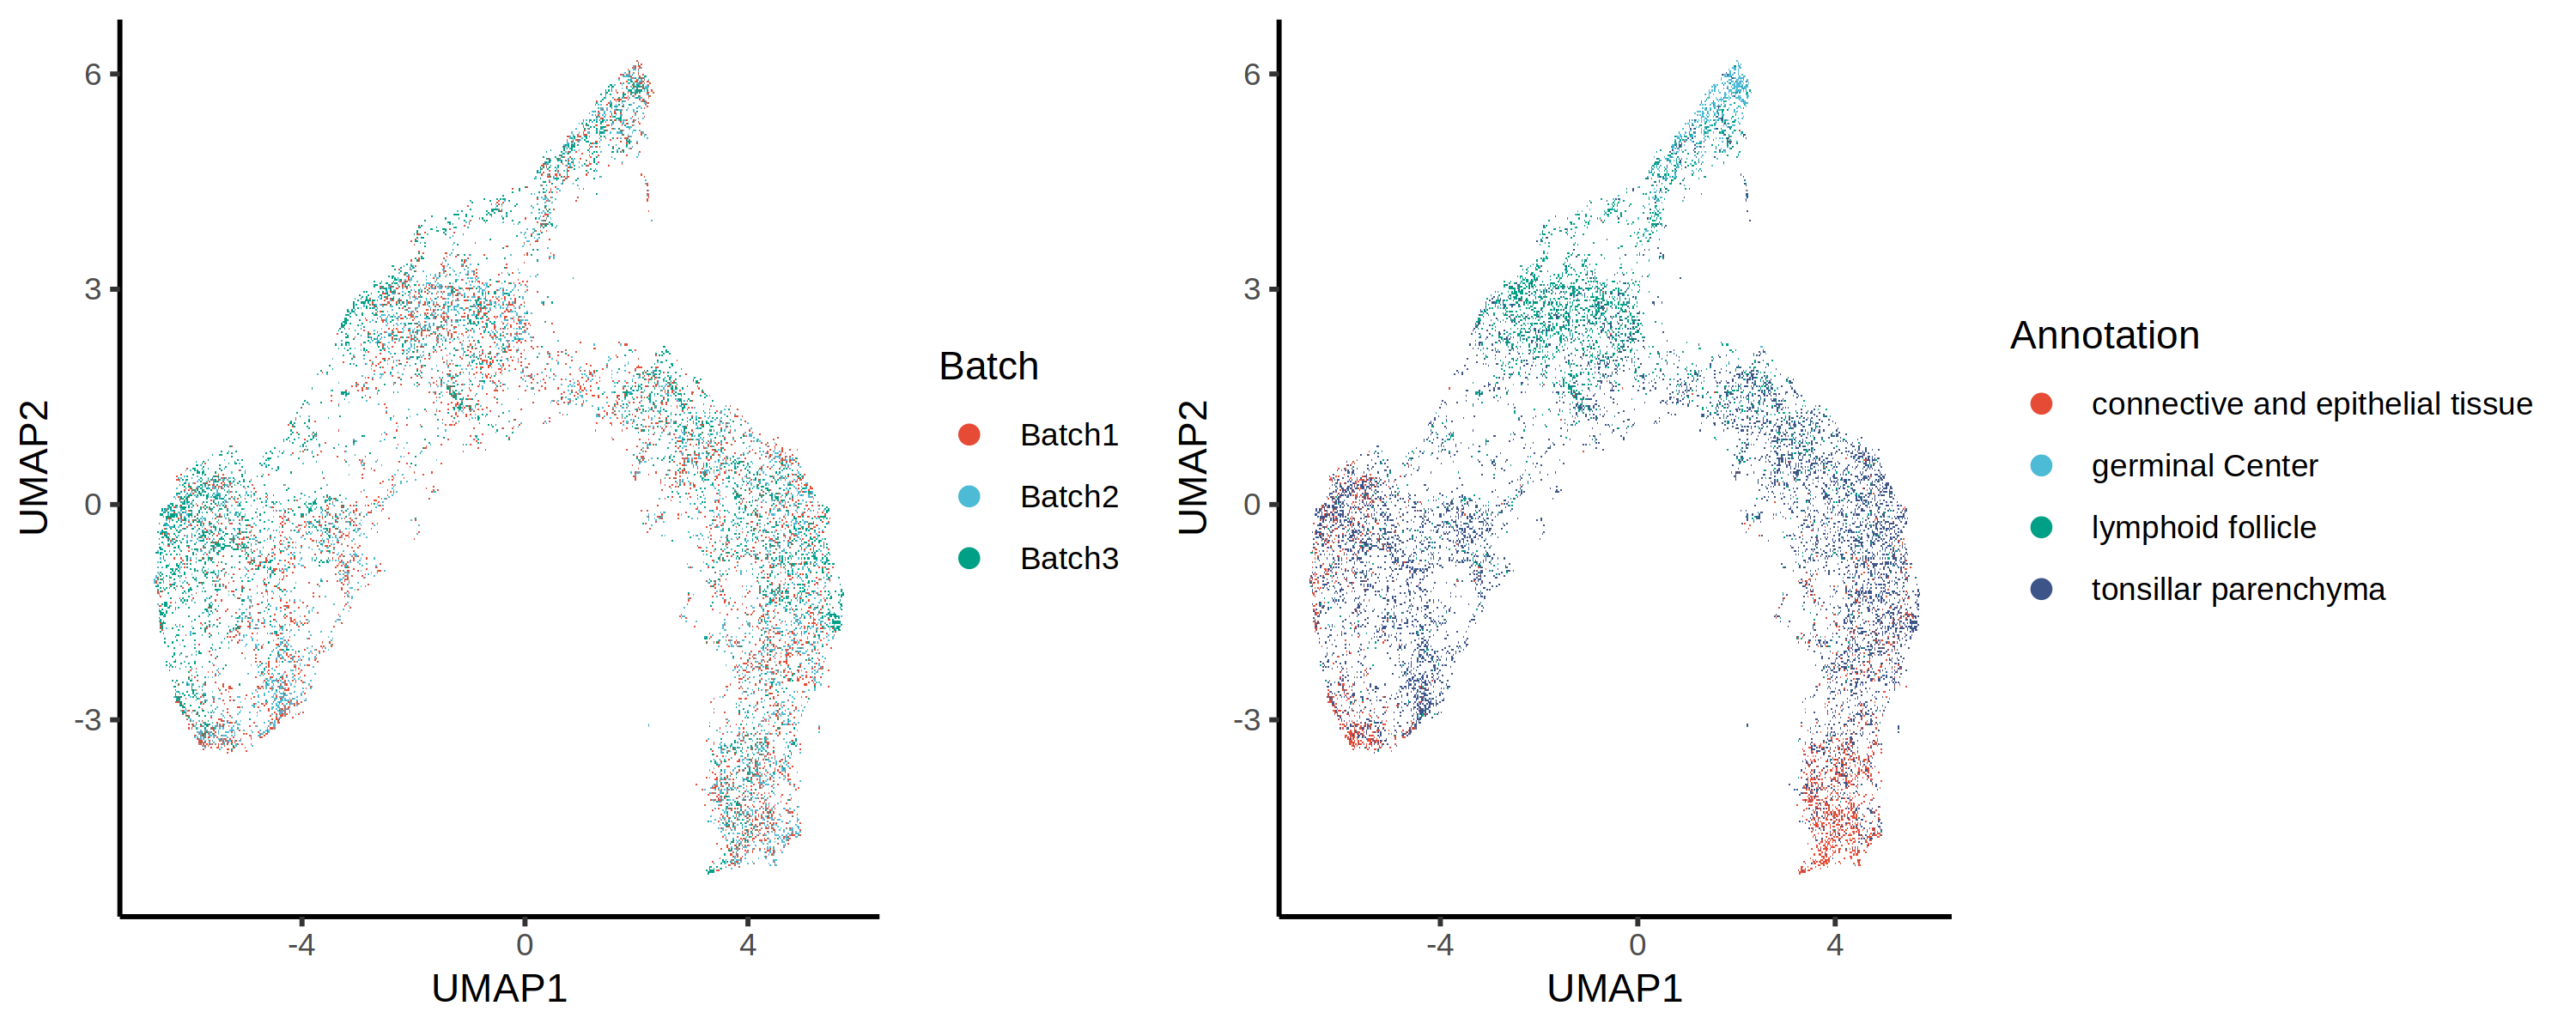

In [14]:
p1 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Batch)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

p2 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Annotation)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

fig.size(4,10)
plot_grid(p1, p2,align = 'h', axis = "b",nrow = 1,rel_widths = c(4.5,5.5))

## Session Info

In [15]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/sqy/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggsci_3.0.3        scattermore_1.2    ggplot2_3.5.1      RColorBrewer_1.1-3
[5] cowplot_1.1.3      uwot_0.2.2         Matrix_1.6-5       PaletteSC_0.1.0   

loaded via a namespace (and not attached):
  [1] Seurat_4.4.0           Rtsne_0.17             colorspace_2.1-1      
  [4] deldir_2.0-4           ggridg